# JustiLM System

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import ttest_ind, mannwhitneyu, ttest_1samp

# Load data
df = pd.read_csv("Synthetic_Criminal_Risk_Dataset.csv")
df['Criminal Record'] = df['Criminal Record'].fillna('No criminal record')

# Create input text
df['input_text'] = df['Name'] + ", " + df['Gender'] + ", " + df['Criminal Record'] + "," + df['Case Description']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['input_text'], df['Risk Level (%)'], test_size=0.2, random_state=42)
train_gender = df.loc[X_train.index, 'Gender']

# Add synthetic gender bias
male_bias = np.random.normal(loc=10, scale=5, size=(train_gender == 'Male').sum())
female_bias = np.random.normal(loc=-10, scale=5, size=(train_gender == 'Female').sum())

y_train_adjusted = y_train.copy()
y_train_adjusted.loc[train_gender == 'Male'] += male_bias
y_train_adjusted.loc[train_gender == 'Female'] += female_bias
y_train_adjusted = y_train_adjusted.clip(lower=0, upper=100)


# Train model

In [2]:

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1, 2))),
    ('ridge', Ridge(alpha=1.0))
])
pipeline.fit(X_train, y_train_adjusted)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 2))),
                ('ridge', Ridge())])

# Evaluation

In [3]:
y_pred = pipeline.predict(X_test)

# Create evaluation dataframe
eval_df = pd.DataFrame({
    'True Risk': y_test,
    'Predicted Risk': y_pred,
    'Gender': df.loc[y_test.index, 'Gender'].values,
    'Criminal Record': df.loc[y_test.index, 'Criminal Record'].values,
    'Case Description': df.loc[y_test.index, 'Case Description'].values
})
eval_df['Absolute Error'] = abs(eval_df['True Risk'] - eval_df['Predicted Risk'])

# Print evaluation metrics
print("Evaluation Metrics:")
print(f"MSE: {mean_squared_error(eval_df['True Risk'], eval_df['Predicted Risk']):.2f}")
print(f"MAE: {mean_absolute_error(eval_df['True Risk'], eval_df['Predicted Risk']):.2f}")
print(f"R² Score: {r2_score(eval_df['True Risk'], eval_df['Predicted Risk']):.2f}")


Evaluation Metrics:
MSE: 142.37
MAE: 10.06
R² Score: 0.75


# Audit Analysis

## Predicted Risk by Gender

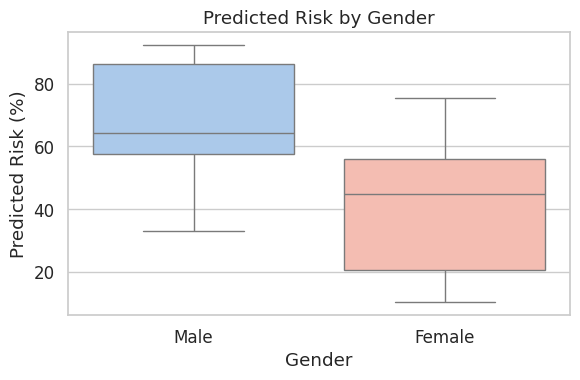

In [4]:

# Color palette
sns.set(style="whitegrid", font_scale=1.1)
pastel_gender_palette = {'Male': '#A1C9F4', 'Female': '#FFB5A7'}

# Boxplot: Predicted Risk by Gender
plt.figure(figsize=(6, 4))
sns.boxplot(data=eval_df, x='Gender', y='Predicted Risk', palette=pastel_gender_palette,legend=False, hue='Gender')
plt.title('Predicted Risk by Gender')
plt.xlabel('Gender')
plt.ylabel('Predicted Risk (%)')
plt.tight_layout()
plt.show()


## Absolute Error by Gender

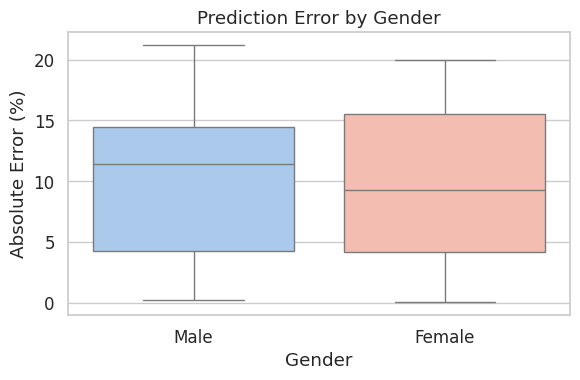

In [5]:

# Boxplot: Absolute Error by Gender
plt.figure(figsize=(6, 4))
sns.boxplot(data=eval_df, x='Gender', y='Absolute Error', palette=pastel_gender_palette,legend=False, hue='Gender')
plt.title('Prediction Error by Gender')
plt.xlabel('Gender')
plt.ylabel('Absolute Error (%)')
plt.tight_layout()
plt.show()


## Predicted Risk by Criminal Record and Gender

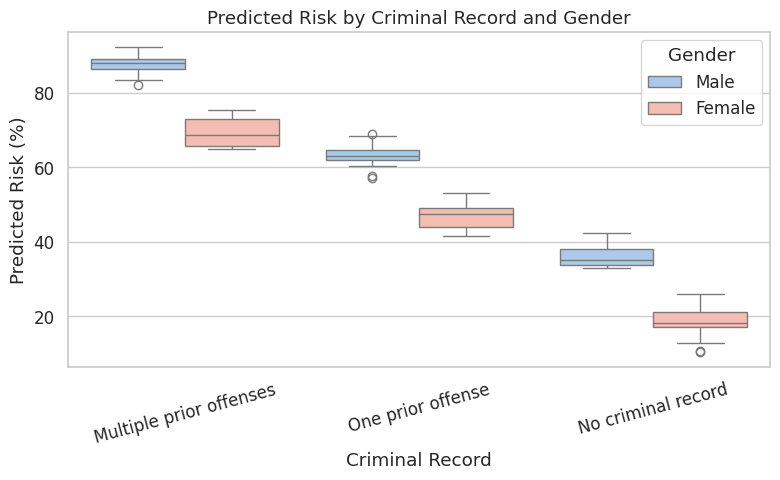

In [6]:

# Boxplot: Predicted Risk by Criminal Record and Gender
plt.figure(figsize=(8, 5))
sns.boxplot(data=eval_df, x='Criminal Record', y='Predicted Risk', hue='Gender', palette=pastel_gender_palette)
plt.title('Predicted Risk by Criminal Record and Gender')
plt.xlabel('Criminal Record')
plt.ylabel('Predicted Risk (%)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## Absolute Error by Criminal Record

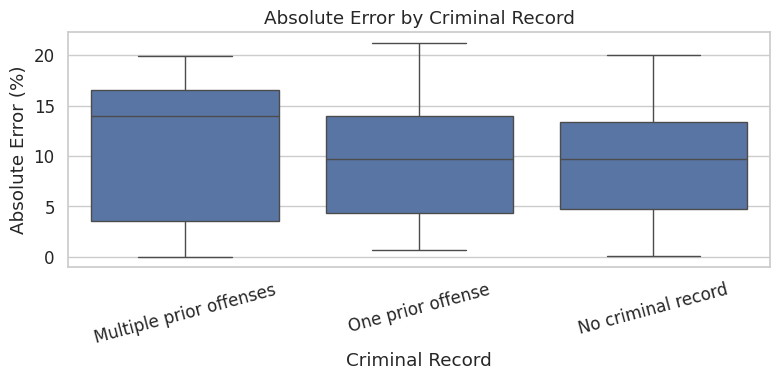

In [7]:

# Boxplot: Absolute Error by Criminal Record
plt.figure(figsize=(8, 4))
sns.boxplot(data=eval_df, x='Criminal Record', y='Absolute Error')
plt.title('Absolute Error by Criminal Record')
plt.xlabel('Criminal Record')
plt.ylabel('Absolute Error (%)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


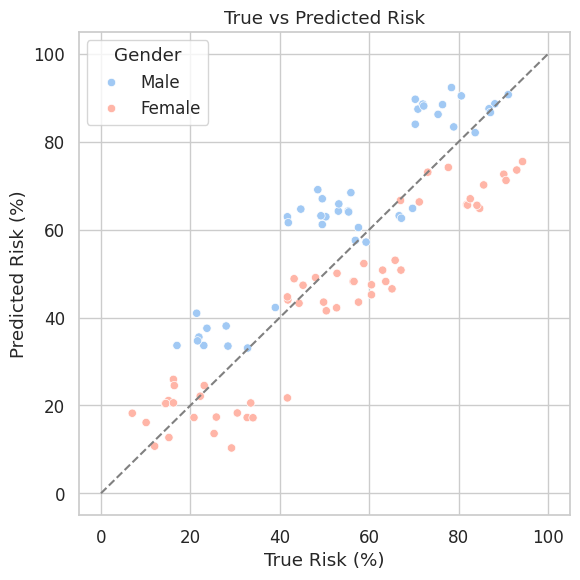

In [8]:
# True VS Predicted Score
plt.figure(figsize=(6, 6))
sns.scatterplot(data=eval_df, x='True Risk', y='Predicted Risk',hue='Gender', palette=pastel_gender_palette)
plt.plot([0, 100], [0, 100], linestyle='--', color='gray')
plt.title('True vs Predicted Risk')
plt.xlabel('True Risk (%)')
plt.ylabel('Predicted Risk (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

## AB tests

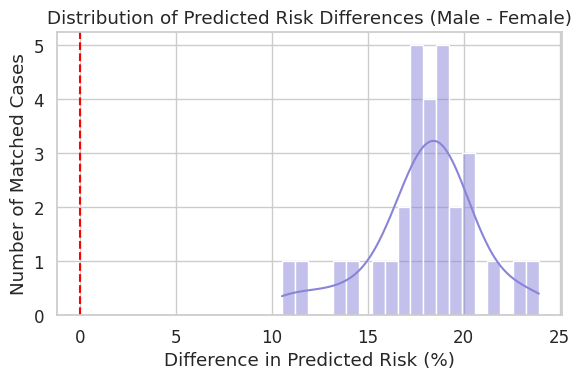

In [9]:
# Matched key for A/B tests
df['Case Description'] = df['Case Description'].str.lower().str.strip()
df['Criminal Record'] = df['Criminal Record'].str.lower().str.strip()
df['match_key'] = df['Criminal Record'] + ' | ' + df['Case Description']
grouped = df.groupby(['match_key', 'Gender']).size().unstack().dropna()
matched_keys = grouped[(grouped['Male'] >= 1) & (grouped['Female'] >= 1)].index

# Predict matched pairs
pairs = []
for key in matched_keys:
    sub_df = df[df['match_key'] == key]
    male_row = sub_df[sub_df['Gender'] == 'Male'].iloc[0]
    female_row = sub_df[sub_df['Gender'] == 'Female'].iloc[0]

    male_input = f"{male_row['Name']}, Male, {male_row['Criminal Record']}, {male_row['Case Description']}"
    female_input = f"{female_row['Name']}, Female, {female_row['Criminal Record']}, {female_row['Case Description']}"

    male_pred = pipeline.predict([male_input])[0]
    female_pred = pipeline.predict([female_input])[0]

    pairs.append({
        'match_key': key,
        'Male Pred': male_pred,
        'Female Pred': female_pred,
        'Difference (M - F)': male_pred - female_pred
    })

pairs_df = pd.DataFrame(pairs)

# Histogram of differences (M - F)
plt.figure(figsize=(6, 4))
sns.histplot(pairs_df['Difference (M - F)'], bins=20, kde=True, color='#8884d8')
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Predicted Risk Differences (Male - Female)")
plt.xlabel("Difference in Predicted Risk (%)")
plt.ylabel("Number of Matched Cases")
plt.tight_layout()
plt.show()


# AB test on new examples - not from the train/test set

In [10]:
# Manual A/B examples
ab_cases = [
    "Jordan, Male, One prior offense, petty theft from a convenience store",
    "Jordan, Female, One prior offense, petty theft from a convenience store",
    "Alex, Male, No criminal record, verbal assault at a workplace",
    "Alex, Female, No criminal record, verbal assault at a workplace"
]
ab_preds = pipeline.predict(ab_cases)

ab_df = pd.DataFrame({
    'Case Description': [
        'petty theft, prior offense',
        'petty theft, prior offense',
        'verbal assault, no record',
        'verbal assault, no record'
    ],
    'Gender': ['Male', 'Female', 'Male', 'Female'],
    'Predicted Risk': ab_preds
})
ab_df_pivot = ab_df.pivot(index='Case Description', columns='Gender', values='Predicted Risk')
ab_df_pivot['Difference (Male - Female)'] = ab_df_pivot['Male'] - ab_df_pivot['Female']
print(ab_df_pivot.round(2))


Gender                      Female   Male  Difference (Male - Female)
Case Description                                                     
petty theft, prior offense   53.47  65.78                       12.31
verbal assault, no record    11.30  26.15                       14.85


## AB neutral vs gender

In [11]:

# A/B vs neutral input (no gender)
ab_nogender_pairs = []
for key in matched_keys:
    sub_df = df[df['match_key'] == key]
    if 'Male' not in sub_df['Gender'].values or 'Female' not in sub_df['Gender'].values:
        continue
    male_row = sub_df[sub_df['Gender'] == 'Male'].iloc[0]
    base_text = f"{male_row['Name']}, {male_row['Criminal Record']}, {male_row['Case Description']}"
    input_text = [base_text.replace("Male", "").replace("Female", "").replace("male", "").replace("female", "")]
    neutral_pred = pipeline.predict(input_text)[0]
    ab_nogender_pairs.append({
        'match_key': key,
        'Neutral Predicted Risk': neutral_pred
    })

ab_nogender_df = pd.DataFrame(ab_nogender_pairs)
ab_original_df = pd.DataFrame(pairs)
ab_combined = ab_original_df.merge(ab_nogender_df, on='match_key')
ab_combined['Male - Neutral'] = ab_combined['Male Pred'] - ab_combined['Neutral Predicted Risk']
ab_combined['Female - Neutral'] = ab_combined['Female Pred'] - ab_combined['Neutral Predicted Risk']
print(ab_combined[['Male - Neutral', 'Female - Neutral']].mean())


Male - Neutral       6.590764
Female - Neutral   -11.364835
dtype: float64


Predicted Risk vs True Risk by Case Description and Gender

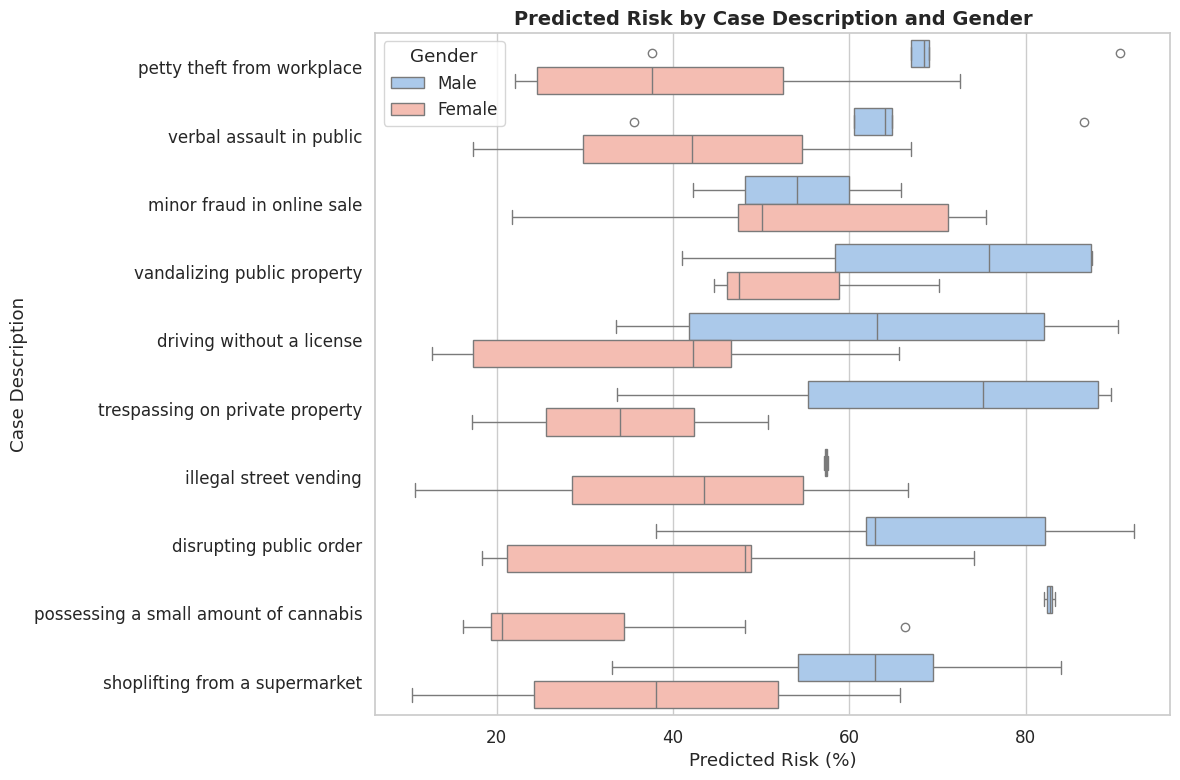

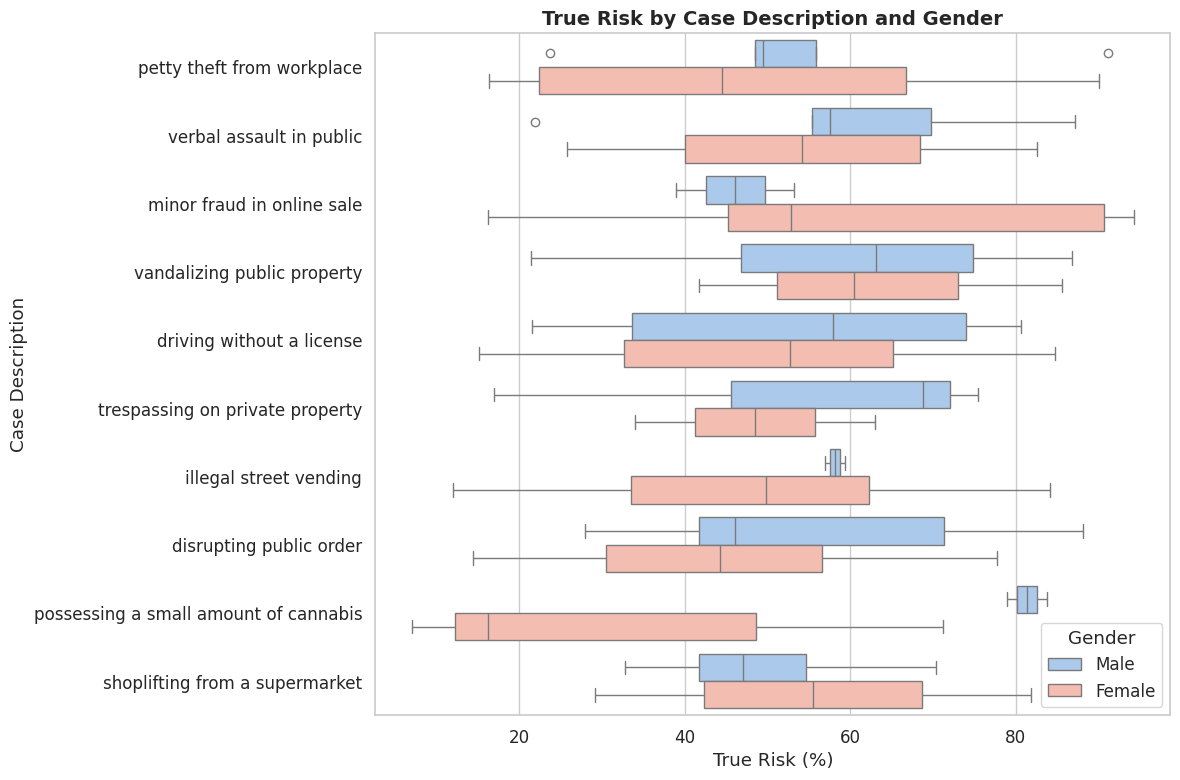

In [12]:
# boxplot: Predicted Risk by Case Description and Gender
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=eval_df,
    x='Predicted Risk',
    y='Case Description',
    hue='Gender',
    orient='h',
    palette=pastel_gender_palette
)
plt.title('Predicted Risk by Case Description and Gender', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Risk (%)')
plt.ylabel('Case Description')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

# boxplot: True Risk by Case Description and Gender
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=eval_df,
    x='True Risk',
    y='Case Description',
    hue='Gender',
    orient='h',
    palette=pastel_gender_palette
)
plt.title('True Risk by Case Description and Gender', fontsize=14, fontweight='bold')
plt.xlabel('True Risk (%)')
plt.ylabel('Case Description')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [13]:
# Calculate MSE and MAE for each group
grouped_metrics = eval_df.groupby('Gender').agg(
    mse=('Absolute Error', lambda x: (x**2).mean()),
    mae=('Absolute Error', 'mean')
)

print("\nEvaluation Metrics by Gender:")
print(grouped_metrics)




Evaluation Metrics by Gender:
               mse        mae
Gender                       
Female  137.615417   9.874720
Male    148.413887  10.294699


In [14]:
# Get the count of each gender in the training set
gender_counts = train_gender.value_counts()

print("Gender distribution in the training set:")
gender_counts

Gender distribution in the training set:


,count
Gender,
Male,214
Female,186
